## Note: Folium maps won't render in Github. You can copy+paste the github url to https://nbviewer.jupyter.org/ to see the folium maps.

### scrape the table from wiki to dataframe

In [264]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import geocoder
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
import folium
from matplotlib import cm
from matplotlib import colors
import getpass
from sklearn.cluster import KMeans
from matplotlib import cm,colors

In [28]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = requests.get(url).text
soup = BeautifulSoup(html,'lxml')

In [3]:
table = soup.find('table', class_="wikitable sortable") #find the table source
postal_df = pd.DataFrame() #create an empty df
for i, row in enumerate(table.find_all('tr')): #<tr> row content </tr> 
    for j, col in enumerate(row.text.strip().split('\n')): #each column content is seperated by \n
        postal_df.loc[i,j] = col #populate postal_df

In [4]:
postal_df.columns = postal_df.iloc[0] #set the first row as header
postal_df.drop(0,axis=0,inplace=True) #drop the first row
postal_df.reset_index(inplace=True, drop=True) #reset the index

In [5]:
postal_df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### Ignore cells with a borough that is Not assigned

In [6]:
postal_df.drop(postal_df[postal_df['Borough']=='Not assigned'].index, axis=0, inplace=True)
postal_df.reset_index(drop=True, inplace=True)
postal_df.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


### Assign neighbourhood the value of the borough if neighborhood Not assigned

In [7]:
for ind in postal_df[postal_df['Neighbourhood']=='Not assigned'].index:
    postal_df.loc[ind,'Neighbourhood']=postal_df.loc[ind,'Borough']
postal_df.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [8]:
postal_df.isnull().any() #check if any null values

0
Postcode         False
Borough          False
Neighbourhood    False
dtype: bool

### group neighbourhoods together in postcode

In [9]:
postcode_neighbourhood_dict={} #create dict with postcode:neighbourhood pairs
for postcode, group in postal_df.groupby('Postcode'):
    postcode_neighbourhood_dict[postcode] = group['Neighbourhood'].values

In [10]:
for i, row in postal_df.iterrows(): #re-assign the Neighbourhood with grouped neighbourhoods
    neighbourhoods = postcode_neighbourhood_dict[row['Postcode']]
    row['Neighbourhood'] = ', '.join(neighbourhoods)

In [11]:
postal_df.drop_duplicates(keep='first',inplace=True) #drop duplicate rows
postal_df.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
4,M6A,North York,"Lawrence Heights, Lawrence Manor"
6,M7A,Queen's Park,Queen's Park


In [12]:
postal_df.shape

(103, 3)

### read the coordinates in the csv file

In [37]:
geo_coor = pd.read_csv('Geospatial_Coordinates.csv') #read in the csv file
geo_coor.rename(columns={'Postal Code':'Postcode'},inplace=True)

In [43]:
Toronto_df = pd.merge(postal_df,geo_coor,on='Postcode') #merge the postal_df and geo_coor
Toronto_df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


### Toronto neighbourhoods

In [104]:
Toronto_df['Borough'].unique()

array(['North York', 'Downtown Toronto', "Queen's Park", 'Etobicoke',
       'Scarborough', 'East York', 'York', 'East Toronto', 'West Toronto',
       'Central Toronto', 'Mississauga'], dtype=object)

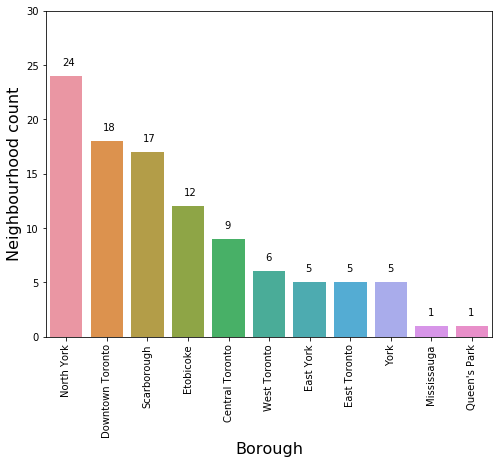

In [76]:
plt.figure(figsize=(8,6))

ax = sns.countplot(Toronto_df['Borough'],order=Toronto_df['Borough'].value_counts().index)
ax.set_xlabel('Borough',fontsize=16)
ax.set_xticklabels(Toronto_df['Borough'].value_counts().index,rotation=90)
ax.set_ylabel('Neighbourhood count',fontsize=16)
ax.set_ylim(0,30)

neighborhood_count = Toronto_df['Borough'].value_counts().values
for i, count in enumerate(neighborhood_count):
    ax.text(i-0.1, count+1, count)

### pinpoint neighbourhoods in map

In [125]:
geolocator = Nominatim(user_agent='capstone_project')
geolocation = geolocator.geocode('Toronto, Canada')
Toronto_lat = geolocation.latitude
Toronto_lng = geolocation.longitude

In [126]:
Toronto_map = folium.Map(location=[Toronto_lat,Toronto_lng],zoom_start=10)

colors_array = cm.rainbow(np.linspace(0,1,Toronto_df['Borough'].nunique()))
rainbow = [colors.rgb2hex(i) for i in colors_array]
    
for i, (borough_name, group) in enumerate(Toronto_df.groupby('Borough')):   
    for j, row in group.iterrows():
        borough=row['Borough']
        neighbourhood=row['Neighbourhood']
        neighborhood_lat = row['Latitude']
        neighborhood_lng = row['Longitude']       
        neighbourhood_label = folium.Popup('{}, {}'.format(neighbourhood,borough),parse_html=True)    
        folium.CircleMarker(location=[neighborhood_lat,neighborhood_lng],
                            color=rainbow[i],
                            fill_color=rainbow[i],
                            fill_opacity=0.7,
                            radius=5,
                            popup=neighbourhood_label).add_to(Toronto_map)
Toronto_map

### focus on boroughs that contain the word Toronto

In [124]:
Toronto = Toronto_df[Toronto_df['Borough'].str.contains('Toronto')]
Toronto.reset_index(drop=True, inplace=True)
Toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
1,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [127]:
Toronto_focus_map = folium.Map(location=[Toronto_lat,Toronto_lng],zoom_start=11)
    
for j, row in Toronto.iterrows():
    borough=row['Borough']
    neighbourhood=row['Neighbourhood']
    neighborhood_lat = row['Latitude']
    neighborhood_lng = row['Longitude']       
    neighbourhood_label = folium.Popup('{}, {}'.format(neighbourhood,borough),parse_html=True)    
    folium.CircleMarker(location=[neighborhood_lat,neighborhood_lng],
                        color='blue',
                        fill_color='#3186cc',
                        fill_opacity=0.7,
                        radius=5,
                        popup=neighbourhood_label).add_to(Toronto_focus_map)
Toronto_focus_map

### Explore the first neighborhood in Toronto(focused)

In [147]:
M5A = Toronto[Toronto['Postcode']=='M5A']
M5A_lat = M5A['Latitude'].values[0]
M5A_lng = M5A['Longitude'].values[0]

In [136]:
#ClientID and Secret
CLIENT_ID = getpass.getpass()
CLIENT_SECRET = getpass.getpass()

········
········


In [149]:
#explore venues in Marble Hill neighborhood
VERSION = '20190624' # Foursquare API version
RADIUS = 500
LIMIT = 100

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    M5A_lat, 
    M5A_lng, 
    RADIUS, 
    LIMIT)

In [183]:
res = requests.get(url).json()
M5A_venue_list = res['response']['groups'][0]['items']
M5A_venue_df = pd.DataFrame(columns=['venue_name','venue_category','venue_lat','venue_lng'])
for i, venue in enumerate(M5A_venue_list):
    venue_name = venue['venue']['name']
    venue_category = venue['venue']['categories'][0]['name']
    venue_lat = venue['venue']['location']['lat']
    venue_lng = venue['venue']['location']['lng']
    M5A_venue_df.loc[i,'venue_name'] = venue_name
    M5A_venue_df.loc[i,'venue_category'] = venue_category
    M5A_venue_df.loc[i,'venue_lat'] = venue_lat
    M5A_venue_df.loc[i,'venue_lng'] = venue_lng
M5A_venue_df.head()

,venue_name,venue_category,venue_lat,venue_lng
0,Roselle Desserts,Bakery,43.6534,-79.362
1,Tandem Coffee,Coffee Shop,43.6536,-79.3618
2,Toronto Cooper Koo Family Cherry St YMCA Centre,Gym / Fitness Center,43.6532,-79.3579
3,Body Blitz Spa East,Spa,43.6547,-79.3599
4,Morning Glory Cafe,Breakfast Spot,43.6539,-79.3611


In [188]:
M5A_map = folium.Map(location=[M5A_lat, M5A_lng], zoom_start=15)

folium.CircleMarker(
            [M5A_lat, M5A_lng],
            radius=8,
            popup=folium.Popup('Harbourfront, Regent Park (Postcode: M5A)', parse_html=True),
            color='red',
            fill=True,
            fill_color='#f44289',
            fill_opacity=0.7).add_to(M5A_map)

for i,row in M5A_venue_df.iterrows():
    venue_name=row[0]
    venue_cat=row[1]
    venue_lat=row[2]
    venue_lng=row[3]
    label = '{}, {}'.format(venue_name, venue_cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
            [venue_lat, venue_lng],
            radius=4,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7).add_to(M5A_map)
M5A_map

### Explore all neighborhoods in Toronto(focused)

In [191]:
neighbourhood_venues = {} #dictionary with neighbourhood:venue_list pairs

for neighbourhood, lat, lng in zip(Toronto['Neighbourhood'],Toronto['Latitude'],Toronto['Longitude']):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    lng, 
    RADIUS, 
    LIMIT)
    res = requests.get(url).json()
    venues_list = res['response']['groups'][0]['items']
    neighbourhood_venues[neighbourhood] = venues_list

In [204]:
def extract_venues_info(venues_list):
    '''
    extract venues info from venues list
    '''   
    venues_name = [venue['venue']['name'] for venue in venues_list]
    venues_category = [venue['venue']['categories'][0]['name'] for venue in venues_list]
    venues_lat = [venue['venue']['location']['lat'] for venue in venues_list]
    venues_lng = [venue['venue']['location']['lng'] for venue in venues_list]
    return venues_name,venues_category,venues_lat,venues_lng

In [207]:
neighbourhood_venue_df = pd.DataFrame(columns=['neighbourhood','venue_name','venue_category','venue_lat','venue_lng'])
neighbourhood_venue_df

,neighbourhood,venue_name,venue_category,venue_lat,venue_lng


In [208]:
#populate the above neighbourhood_venue_df

for neighbourhood, venues_list in neighbourhood_venues.items():
    venues_name,venues_category,venues_lat,venues_lng = extract_venues_info(venues_list)
    temp_df = pd.DataFrame({'neighbourhood':neighbourhood, 'venue_name':venues_name, 
                            'venue_category':venues_category,'venue_lat':venues_lat, 'venue_lng':venues_lng})
    print(neighbourhood, temp_df.shape[0])
    neighbourhood_venue_df = pd.concat((neighbourhood_venue_df,temp_df),axis=0)

neighbourhood_venue_df.head()

Harbourfront, Regent Park 48
Ryerson, Garden District 100
St. James Town 100
The Beaches 5
Berczy Park 55
Central Bay Street 88
Christie 15
Adelaide, King, Richmond 100
Dovercourt Village, Dufferin 20
Harbourfront East, Toronto Islands, Union Station 100
Little Portugal, Trinity 62
The Danforth West, Riverdale 42
Design Exchange, Toronto Dominion Centre 100
Brockton, Exhibition Place, Parkdale Village 22
The Beaches West, India Bazaar 18
Commerce Court, Victoria Hotel 100
Studio District 38
Lawrence Park 3
Roselawn 2
Davisville North 9
Forest Hill North, Forest Hill West 4
High Park, The Junction South 23
North Toronto West 16
The Annex, North Midtown, Yorkville 23
Parkdale, Roncesvalles 15
Davisville 38
Harbord, University of Toronto 34
Runnymede, Swansea 38
Moore Park, Summerhill East 2
Chinatown, Grange Park, Kensington Market 100
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West 14
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway

,neighbourhood,venue_name,venue_category,venue_lat,venue_lng
0,"Harbourfront, Regent Park",Roselle Desserts,Bakery,43.653447,-79.362017
1,"Harbourfront, Regent Park",Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,"Harbourfront, Regent Park",Toronto Cooper Koo Family Cherry St YMCA Centre,Gym / Fitness Center,43.653191,-79.357947
3,"Harbourfront, Regent Park",Body Blitz Spa East,Spa,43.654735,-79.359874
4,"Harbourfront, Regent Park",Morning Glory Cafe,Breakfast Spot,43.653947,-79.361149


In [212]:
neighbourhood_venue_df.reset_index(inplace=True, drop=True)
neighbourhood_venue_df.shape

(1700, 5)

In [222]:
Toronto.columns = ['postcode','borough','neighbourhood','neighbourhood_lat','neighbourhood_lng']
Toronto.head()

,postcode,borough,neighbourhood,neighbourhood_lat,neighbourhood_lng
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
1,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [223]:
#merge neighbourhood_venue_df and Toronto together on neighbourhood
Toronto_venue_df = pd.merge(Toronto,neighbourhood_venue_df,on='neighbourhood')
Toronto_venue_df.head()

,postcode,borough,neighbourhood,neighbourhood_lat,neighbourhood_lng,venue_name,venue_category,venue_lat,venue_lng
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.65426,-79.360636,Roselle Desserts,Bakery,43.653447,-79.362017
1,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.65426,-79.360636,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.65426,-79.360636,Toronto Cooper Koo Family Cherry St YMCA Centre,Gym / Fitness Center,43.653191,-79.357947
3,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.65426,-79.360636,Body Blitz Spa East,Spa,43.654735,-79.359874
4,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.65426,-79.360636,Morning Glory Cafe,Breakfast Spot,43.653947,-79.361149


In [230]:
print('There are {} venues with {} categories in Toronto (focused).'.format(Toronto_venue_df.shape[0],
                                                                          Toronto_venue_df['venue_category'].nunique()))

There are 1700 venues with 238 categories in Toronto (focused).


### analyze each neighbourhood in Toronto

In [231]:
Toronto_venue_onehot = pd.get_dummies(Toronto_venue_df[['venue_category']],prefix='',prefix_sep='')

In [233]:
Toronto_venue_onehot = pd.concat((Toronto_venue_df[['neighbourhood']],Toronto_venue_onehot),axis=1)
Toronto_venue_onehot.head()

,neighbourhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [234]:
#group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
Toronto_venue_grouped = Toronto_venue_onehot.groupby('neighbourhood').mean().reset_index()
Toronto_venue_grouped.head()

,neighbourhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.04,...,0.0,0.0,0.010000,0.0,0.0,0.0,0.01,0.0,0.0,0.000000
1,Berczy Park,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.00,...,0.0,0.0,0.018182,0.0,0.0,0.0,0.00,0.0,0.0,0.000000
2,"Brockton, Exhibition Place, Parkdale Village",0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.045455
3,Business Reply Mail Processing Centre 969 Eastern,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.052632
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.0,0.0,0.0625,0.0625,0.0625,0.125,0.125,0.125,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000


In [239]:
#each neighborhood's top5 most frequent venues
for i, row in Toronto_venue_grouped.iterrows():
    neighbourhood = row['neighbourhood']
    venues = row[1:]
    venues_sorted = venues.sort_values(ascending=False)
    print('---'+neighbourhood+'---')
    for venue,freq_value in venues_sorted[:5].iteritems():      
        print('{:<30}  {:>30.2f}'.format(venue, freq_value))
    print('\n')

---Adelaide, King, Richmond---
Coffee Shop                                               0.05
Café                                                      0.05
Steakhouse                                                0.04
Bar                                                       0.04
American Restaurant                                       0.04


---Berczy Park---
Coffee Shop                                               0.09
Cocktail Bar                                              0.05
Steakhouse                                                0.04
Bakery                                                    0.04
Café                                                      0.04


---Brockton, Exhibition Place, Parkdale Village---
Breakfast Spot                                            0.09
Café                                                      0.09
Coffee Shop                                               0.09
Yoga Studio                                               0.05
Intersection  

### create the new dataframe of top 10 venues for each neighbourhood

In [241]:
columns = ['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue'] +\
          [str(i+1)+'th Most Common Venue' for i in range(3,10)]

Toronto_venue_top10 = pd.DataFrame(columns=columns)
Toronto_venue_top10['neighbourhood'] = Toronto_venue_grouped['neighbourhood']
Toronto_venue_top10.set_index('neighbourhood',inplace=True)
Toronto_venue_top10.reset_index(inplace=True)
Toronto_venue_top10.head()

,neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Berczy Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Brockton, Exhibition Place, Parkdale Village",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Business Reply Mail Processing Centre 969 Eastern,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [242]:
for i, row in Toronto_venue_grouped.iterrows():
    Toronto_venue_top10.iloc[i,1:] = row[1:].sort_values(ascending=False)[:10].index
Toronto_venue_top10.head()

,neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Bar,American Restaurant,Bakery,Restaurant,Hotel,Burger Joint,Cosmetics Shop
1,Berczy Park,Coffee Shop,Cocktail Bar,Steakhouse,Bakery,Café,Cheese Shop,Seafood Restaurant,Beer Bar,Italian Restaurant,Farmers Market
2,"Brockton, Exhibition Place, Parkdale Village",Breakfast Spot,Café,Coffee Shop,Yoga Studio,Intersection,Performing Arts Venue,Caribbean Restaurant,Stadium,Restaurant,Bar
3,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Auto Workshop,Comic Shop,Pizza Place,Recording Studio,Restaurant,Butcher,Burrito Place,Skate Park,Brewery
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Terminal,Airport Lounge,Airport Service,Boutique,Coffee Shop,Boat or Ferry,Sculpture Garden,Harbor / Marina,Plane,Airport Gate


### clustering the neighbourhoods

In [243]:
Toronto_venue_grouped.head()

,neighbourhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.04,...,0.0,0.0,0.010000,0.0,0.0,0.0,0.01,0.0,0.0,0.000000
1,Berczy Park,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.00,...,0.0,0.0,0.018182,0.0,0.0,0.0,0.00,0.0,0.0,0.000000
2,"Brockton, Exhibition Place, Parkdale Village",0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.045455
3,Business Reply Mail Processing Centre 969 Eastern,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.052632
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.0,0.0,0.0625,0.0625,0.0625,0.125,0.125,0.125,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000


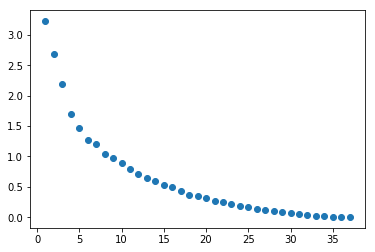

In [256]:
#Run k-means to cluster the neighborhood 
Toronto_venue_clustering = Toronto_venue_grouped.drop('neighbourhood',axis=1)
k_intertia = {}
for k in range(1,Toronto_venue_clustering.shape[0]):
    kmean = KMeans(n_clusters=k)
    kmean.fit(Toronto_venue_clustering)
    k_intertia[k] = kmean.inertia_
plt.scatter(k_intertia.keys(),k_intertia.values())

In [265]:
#it seems k=4 is a reasonable choice of clusters
num_clusters = 4
kmean = KMeans(n_clusters=num_clusters)
kmean.fit(Toronto_venue_clustering)
neighbourhood_label = kmean.labels_
neighbourhood_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       3, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [266]:
Toronto_venue_merged = pd.merge(Toronto,Toronto_venue_top10,on='neighbourhood')
Toronto_venue_merged['label'] = neighbourhood_label
Toronto_venue_merged.head()

,postcode,borough,neighbourhood,neighbourhood_lat,neighbourhood_lng,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,label
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,Coffee Shop,Bakery,Pub,Park,Theater,Breakfast Spot,Restaurant,Mexican Restaurant,Café,Yoga Studio,0
1,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Tea Room,Italian Restaurant,Diner,Pizza Place,Bubble Tea Shop,0
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,Coffee Shop,Café,Hotel,Restaurant,Breakfast Spot,Gastropub,Cosmetics Shop,Clothing Store,Cocktail Bar,Bakery,0
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,Health Food Store,Pub,Trail,Neighborhood,Other Great Outdoors,Falafel Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Filipino Restaurant,0
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,Coffee Shop,Cocktail Bar,Steakhouse,Bakery,Café,Cheese Shop,Seafood Restaurant,Beer Bar,Italian Restaurant,Farmers Market,0


In [277]:
geolocator = Nominatim(user_agent='capstone_project')
location = geolocator.geocode('Toronto, Canada')
Toronto_lat = location.latitude
Toronto_lng = location.longitude

Toronto_clusters = folium.Map(location=[Toronto_lat, Toronto_lng], zoom_start=11)
color_arrays = cm.rainbow(np.linspace(0,1,num_clusters))
rainbow_colors = [colors.rgb2hex(i) for i in color_arrays]

for lat, lng, neighbourhood, cluster in zip(Toronto_venue_merged['neighbourhood_lat'], 
                                            Toronto_venue_merged['neighbourhood_lng'], 
                                            Toronto_venue_merged['neighbourhood'], 
                                            Toronto_venue_merged['label']):
    label = folium.Popup(str(neighbourhood) + ': Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow_colors[cluster],
        fill=True,
        fill_color=rainbow_colors[cluster],
        fill_opacity=0.7).add_to(Toronto_clusters)
       
Toronto_clusters